# stacking

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

# Jupyter上で図を表示するためのコマンド
%matplotlib inline

In [48]:
def importances(model):
    """ 変数重要度
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.barh(range(len(indices)), importances[indices] , align='center')
    plt.yticks(range(len(indices)), feature_X[indices])
    plt.title('decision tree feature importance')
    plt.xlabel('feature importance')
    plt.ylabel('variable')
    plt.show()

In [49]:
yName='LoanStatus'

In [50]:
# pickleで読込む
import pickle

# 前処理済みデータ取得
with open('../data/dataset/pre/pre_data.pickle','rb') as f:
    pre_data = pickle.load(f)

In [51]:
# 欠損値処理
pre_data=pre_data.fillna(pre_data.mean())

In [52]:
# 目的変数と説明変数の取得
y=pre_data['LoanStatus']
X=pre_data.drop(columns='LoanStatus')

In [53]:
random_state = 1021

In [54]:
# 訓練データとテストデータの分割
X_train_valid, X_meta_valid, y_train_valid, y_meta_valid = train_test_split(X, y, test_size=0.2, random_state=random_state)

# 訓練データと検証データの分割
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.5, random_state=random_state)

In [56]:
# 調整済みモデル取得
with open('../data/models/model_lightgbm.pickle','rb') as f:
    model_lightgbm = pickle.load(f)

In [57]:
# train base model
base_model_1 = XGBClassifier()
base_model_2 = LGBMClassifier()
base_model_3 = KNeighborsClassifier()
base_model_4 = RandomForestClassifier()

In [58]:
base_model_1.fit(X_train, y_train)
base_model_2.fit(X_train, y_train)
base_model_3.fit(X_train, y_train)
base_model_4.fit(X_train, y_train)

c:\users\sirec\anaconda3\envs\datascience\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:56:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


AttributeError: 'Booster' object has no attribute 'fit'

In [18]:
# base predicts
base_pred_1 = base_model_1.predict(X_valid)
base_pred_2 = base_model_2.predict(X_valid)
base_pred_3 = base_model_3.predict(X_valid)
base_pred_4 = base_model_4.predict(X_valid)

In [19]:
# test predicts for final result 
valid_pred_1 = base_model_1.predict(X_meta_valid)
valid_pred_2 = base_model_2.predict(X_meta_valid)
valid_pred_3 = base_model_3.predict(X_meta_valid)
valid_pred_4 = base_model_4.predict(X_meta_valid)

print ("f1_score of model 1: {:.4f}".format(f1_score(y_meta_valid, valid_pred_1)) )
print ("f1_score of model 2: {:.4f}".format(f1_score(y_meta_valid, valid_pred_2)) )
print ("f1_score of model 3: {:.4f}".format(f1_score(y_meta_valid, valid_pred_3)) )
print ("f1_score of model 4: {:.4f}".format(f1_score(y_meta_valid, valid_pred_3)) )

f1_score of model 1: 0.8551
f1_score of model 2: 0.8501
f1_score of model 3: 0.2612
f1_score of model 4: 0.2612


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

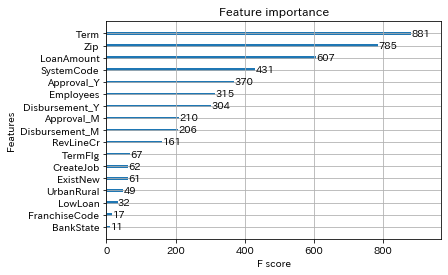

In [20]:
# 重要度の可視化
xgb.plot_importance(base_model_1,max_num_features=20)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

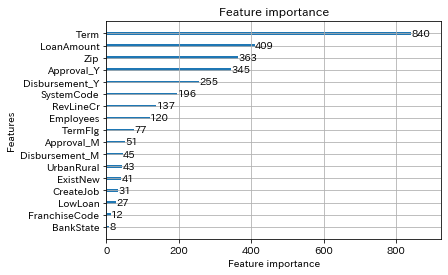

In [21]:
lgb.plot_importance(base_model_2,max_num_features=20)

In [30]:
importances(base_model_3)

AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'

In [31]:
# 変数重要度を見るため、変数名を取り出しておく
feature_X = X.columns
feature_y = y.name

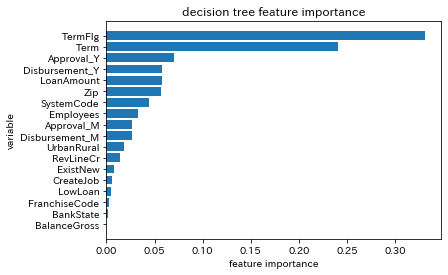

In [32]:
importances(base_model_4)

In [33]:
# stack base predicts for training meta model
stacked_predictions = np.column_stack((base_pred_1, base_pred_2, base_pred_3, base_pred_4))

# stack test predicts for final result 
stacked_valid_predictions = np.column_stack((valid_pred_1, valid_pred_2, valid_pred_3, valid_pred_4))

# train meta model 
meta_model =  XGBClassifier()
meta_model.fit(stacked_predictions, y_valid)

# final result 
meta_valid_pred = meta_model.predict(stacked_valid_predictions)
print ("f1_score of meta model: {:.4f}".format(f1_score(y_meta_valid, meta_valid_pred)) )

c:\users\sirec\anaconda3\envs\datascience\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:41:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1_score of meta model: 0.8550


In [42]:
# モデルの保存
with open('../data/models/Stacking_XLKM_submission.pickle', mode='wb') as f:
    pickle.dump(meta_model, f)

In [45]:
# テストデータの取得
with open('../data/dataset/test/test_cleaned_data.pickle','rb') as f:
    c_data = pickle.load(f)

In [46]:
# 予測
pred_data = meta_model.predict(c_data)

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3'] ['Term', 'Approval_Y', 'Approval_M', 'Disbursement_Y', 'Disbursement_M', 'TermFlg', 'RevLineCr', 'LowLoan', 'LoanAmount', 'BalanceGross', 'SystemCode', 'Employees', 'ExistNew', 'CreateJob', 'FranchiseCode', 'Zip', 'BankState', 'UrbanRural']
expected f0, f2, f3, f1 in input data
training data did not have the following fields: Approval_Y, ExistNew, RevLineCr, CreateJob, TermFlg, SystemCode, BalanceGross, Employees, Term, LoanAmount, Disbursement_Y, Disbursement_M, LowLoan, FranchiseCode, Zip, UrbanRural, Approval_M, BankState

In [ ]:
# 提出サンプルデータの読み込み
df_submission = pd.read_csv('../data/raw/sample_submission.csv')

In [ ]:
# 提出用のデータを作成し、csv形式で保存
df_submission['LoanStatus'] = pred_y
df_submission.to_csv('../data/_submit/Stacking_XLKM_submission.csv', index=False)